In [1]:
#Control time packages
import time
import os

os.environ["OMP_NUM_THREADS"] = "1"


import numpy as np
import matplotlib.pyplot as plt
from plotbin.plot_velfield import plot_velfield
from My_Jampy import JAM                          #My class for jampy


from astropy.cosmology import Planck15 as cosmo
import astropy.units as u

from schwimmbad import MPIPool
"""
We will use one beta for gaussian in MGE, except for the two first. AS it have sigma < pixscale, we will use the same beta for both.

"""
boundary = {"ml0": [0.5, 15], "delta": [0.1, 2], "lower": [0, 1],  "qinc": [0.051, 0.468808],
             "beta0": [-3, 3],"beta1": [-3, 3],"beta2": [-3, 3],"beta3": [-3, 3],"beta4": [-3, 3],"beta5": [-3, 3],"beta6": [-3, 3],"beta7": [-3, 3],
             "log_mbh": [7, 11]}

def gaussian_ml(sigma, delta, ml0=1.0, lower=0.4):
    """
    Create a M*L gradient
    Input:
    -----------
        sigma: Gaussian sigma                           [arcsec]
        delta: Gradient value
        ml0: Central stellar mass to light ratio        [M_sun/L_sun]    
        lower: the ratio between the central and the outer most M/L
    Output:
    ----------
        ML: gaussian mass to light ratio. One component per gaussian in surf_lum.
    """

    sigma = np.atleast_1d(sigma)
    sigma = sigma - sigma[0]
    ML = ml0 * (lower + (1-lower)*np.exp(-0.5 * (sigma * delta)**2))
    
    return ML


class Model(object):
    def __init__(self, Jam_model):
        self.Jam_model = Jam_model

    def prior_transform(self, theta):
        ml0, delta, lower, qinc, beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7, log_mbh = theta
        parsDic = {"ml0":ml0, "delta": delta, "lower": lower, "qinc":qinc, 
                    "beta0":beta0,"beta1":beta1,"beta2":beta2,"beta3":beta3,"beta4":beta4,  "beta5":beta5,"beta6":beta6,"beta7":beta7, 
                    "log_mbh":log_mbh}
        for key in parsDic:
            parsDic[key] = boundary[key][0] + parsDic[key]*(boundary[key][1] - boundary[key][0])
        
        return np.array(list(parsDic.values()))

    def log_likelihood(self, theta):
        ml0, delta, lower, qinc, beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7, log_mbh = theta
        # Sample inclination using min(q), with Equation (14) of Cappellari (2008)
        qmin = np.min(self.Jam_model.qobs_lum)
        inc_model = np.degrees(np.arctan(np.sqrt((1 - qmin**2)/(qmin**2 -qinc**2))))
        

        beta_model  = np.array([beta0,beta0,beta1,beta2,beta3,beta4,beta5,beta6,beta7])
        ml_model    = gaussian_ml(sigma=self.Jam_model.sigma_lum, ml0=ml0, delta=delta, lower=lower)
        mbh_model   = 10**log_mbh
        
        self.Jam_model.upt(inc=inc_model, ml=ml_model, beta=beta_model, mbh=mbh_model)
        
        rmsModel, ml, chi2, chi2T = self.Jam_model.run(quiet=False, plot=True)
        
        
        return -0.5 * chi2T

    def __call__(self, pars):
        return self.log_likelihood(pars)

def resume_dlogz(sampler):
        results = sampler.results
        logz_remain = np.max(sampler.live_logl) + results.logvol[-1]
        delta_logz = np.logaddexp(results.logz[-1], logz_remain) - results.logz[-1]
        
        return delta_logz

In [2]:
# Reading Data
x, y, vrms, erms              = np.loadtxt("Input/Vrms_map_rot.txt", unpack=True)           #vrms data
surf_lum, sigma_lum, qobs_lum = np.loadtxt("Input/JAM_Input.txt", unpack=True)              #MGE decomposition
norm_psf, sigma_psf           = np.loadtxt("Input/MUSE_Psf_model.txt", unpack=True)         #PSF

# Defing some inputs
z_l     = 0.299                                                         #Redshift
D_l     = cosmo.angular_diameter_distance(z_l).value                    #Distance to Lens [Mpc] 
mbh     = 1e9                                                           #mass of black hole [log10(M_sun)]
beta    = np.full_like(surf_lum, -0.15)                                 #anisotropy [ad]
inc     = 65                                                            #inclination [deg]
ml      = gaussian_ml(sigma_lum, delta=0.5, ml0=7.0, lower=0.4)         #mass to light ratio
inc_rad = np.radians(inc)
qinc    = np.sqrt(np.min(qobs_lum)**2 - 
                        (1 - np.min(qobs_lum)**2)/np.tan(inc_rad)**2)   #Deprojected axial ratio for inclination

pixsize = 0.2    #MUSE pixel size



In [3]:
bad1 = 187.7150268554688
bad2 = 232.4691925048828

goodbins = (vrms != bad1) & (vrms != bad2)

In [4]:
# Now we start our Jampy class
Jam_model = JAM(ybin=y*pixsize, xbin=x*pixsize, inc=inc, distance=D_l, mbh=mbh, beta=beta, rms=vrms, erms=erms,
                goodbins=goodbins, normpsf=norm_psf, sigmapsf=sigma_psf*pixsize, pixsize=pixsize,)

#Add Luminosity component
Jam_model.luminosity_component(surf_lum=surf_lum, sigma_lum=sigma_lum,
                                    qobs_lum=qobs_lum, ml=ml)

model = Model(Jam_model=Jam_model)

In [5]:
import pickle
from dynesty import plotting as dyplot
from dynesty import utils as dyfunc

with open(f'final_jam_gaussianML_noDM_MultiBeta.pickle','rb') as f:
    sample_load = pickle.load(f)

In [6]:
results = sample_load.results
results.summary()

Summary
nlive: 150
niter: 5146
ncall: 186323
eff(%):  2.842
logz: -155.371 +/-  0.610


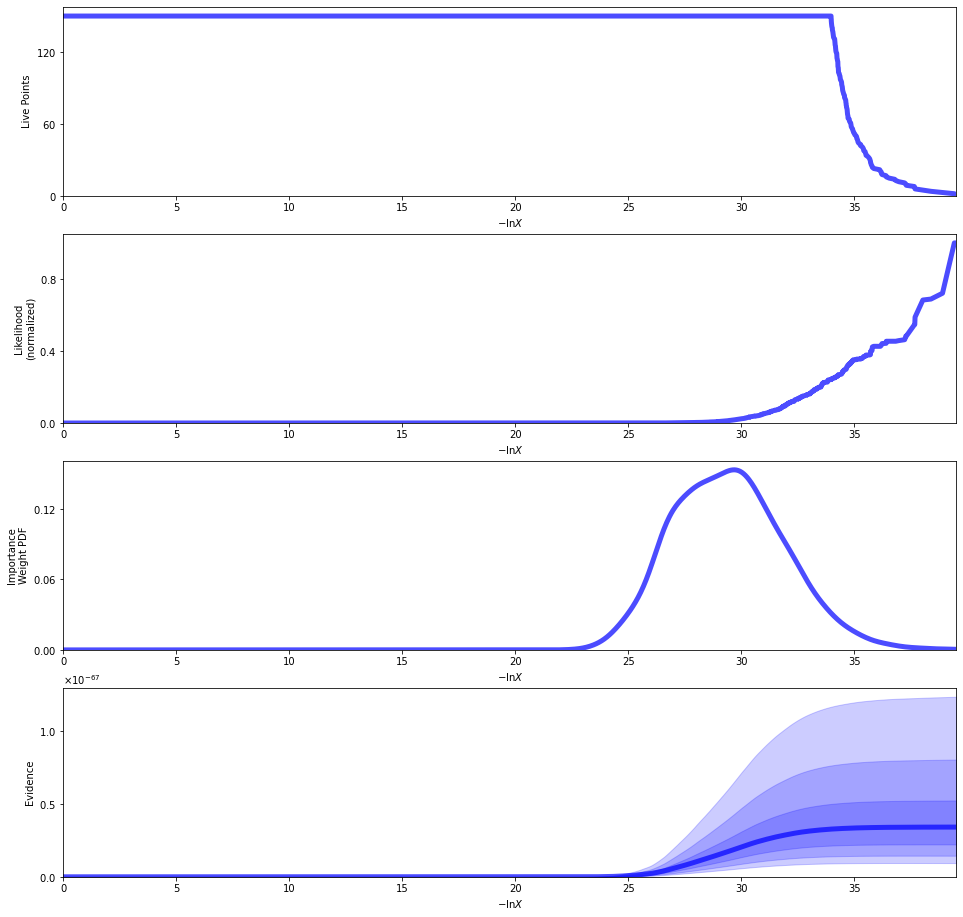

In [7]:
fig, axes = dyplot.runplot(dyfunc.simulate_run(sample_load.results))

In [8]:
# Generate a new set of results with statistical+sampling uncertainties.
results_sim = dyfunc.simulate_run(sample_load.results)


samples_sim = results_sim.samples
weights = np.exp(results_sim.logwt - results_sim.logz[-1])  # normalized weights
mean, cov = dyfunc.mean_and_cov(samples_sim, weights)
mean, cov

(array([ 4.43698191,  0.61281215,  0.91528288,  0.35070881,  1.86283211,
        -1.60124671,  0.68099509, -1.32886175,  1.50999529,  1.60900133,
        -0.35816574,  0.89107931,  7.98336669]),
 array([[ 4.49235370e-03,  5.17383557e-03, -1.89075685e-03,
          3.24558198e-03, -1.59298735e-02,  7.46207835e-03,
         -1.06919823e-03, -4.55721063e-02,  6.28086364e-03,
         -1.14078523e-02,  4.42017872e-03, -3.91793146e-04,
         -2.86697616e-03],
        [ 5.17383557e-03,  1.77800038e-01,  8.01095404e-03,
         -5.95807663e-03,  2.35076216e-02,  4.47985772e-02,
          2.85801270e-03, -2.97735693e-02, -4.12784078e-03,
         -1.39047536e-02,  2.13475595e-03,  9.48833908e-04,
         -1.37488838e-02],
        [-1.89075685e-03,  8.01095404e-03,  4.91015240e-03,
         -3.01819997e-04,  2.43922980e-02, -3.70913908e-03,
          7.52416199e-04,  3.29863073e-03, -5.17616683e-03,
          7.09764940e-03, -3.09677182e-03,  7.43909348e-05,
         -8.66192438e-03],
    

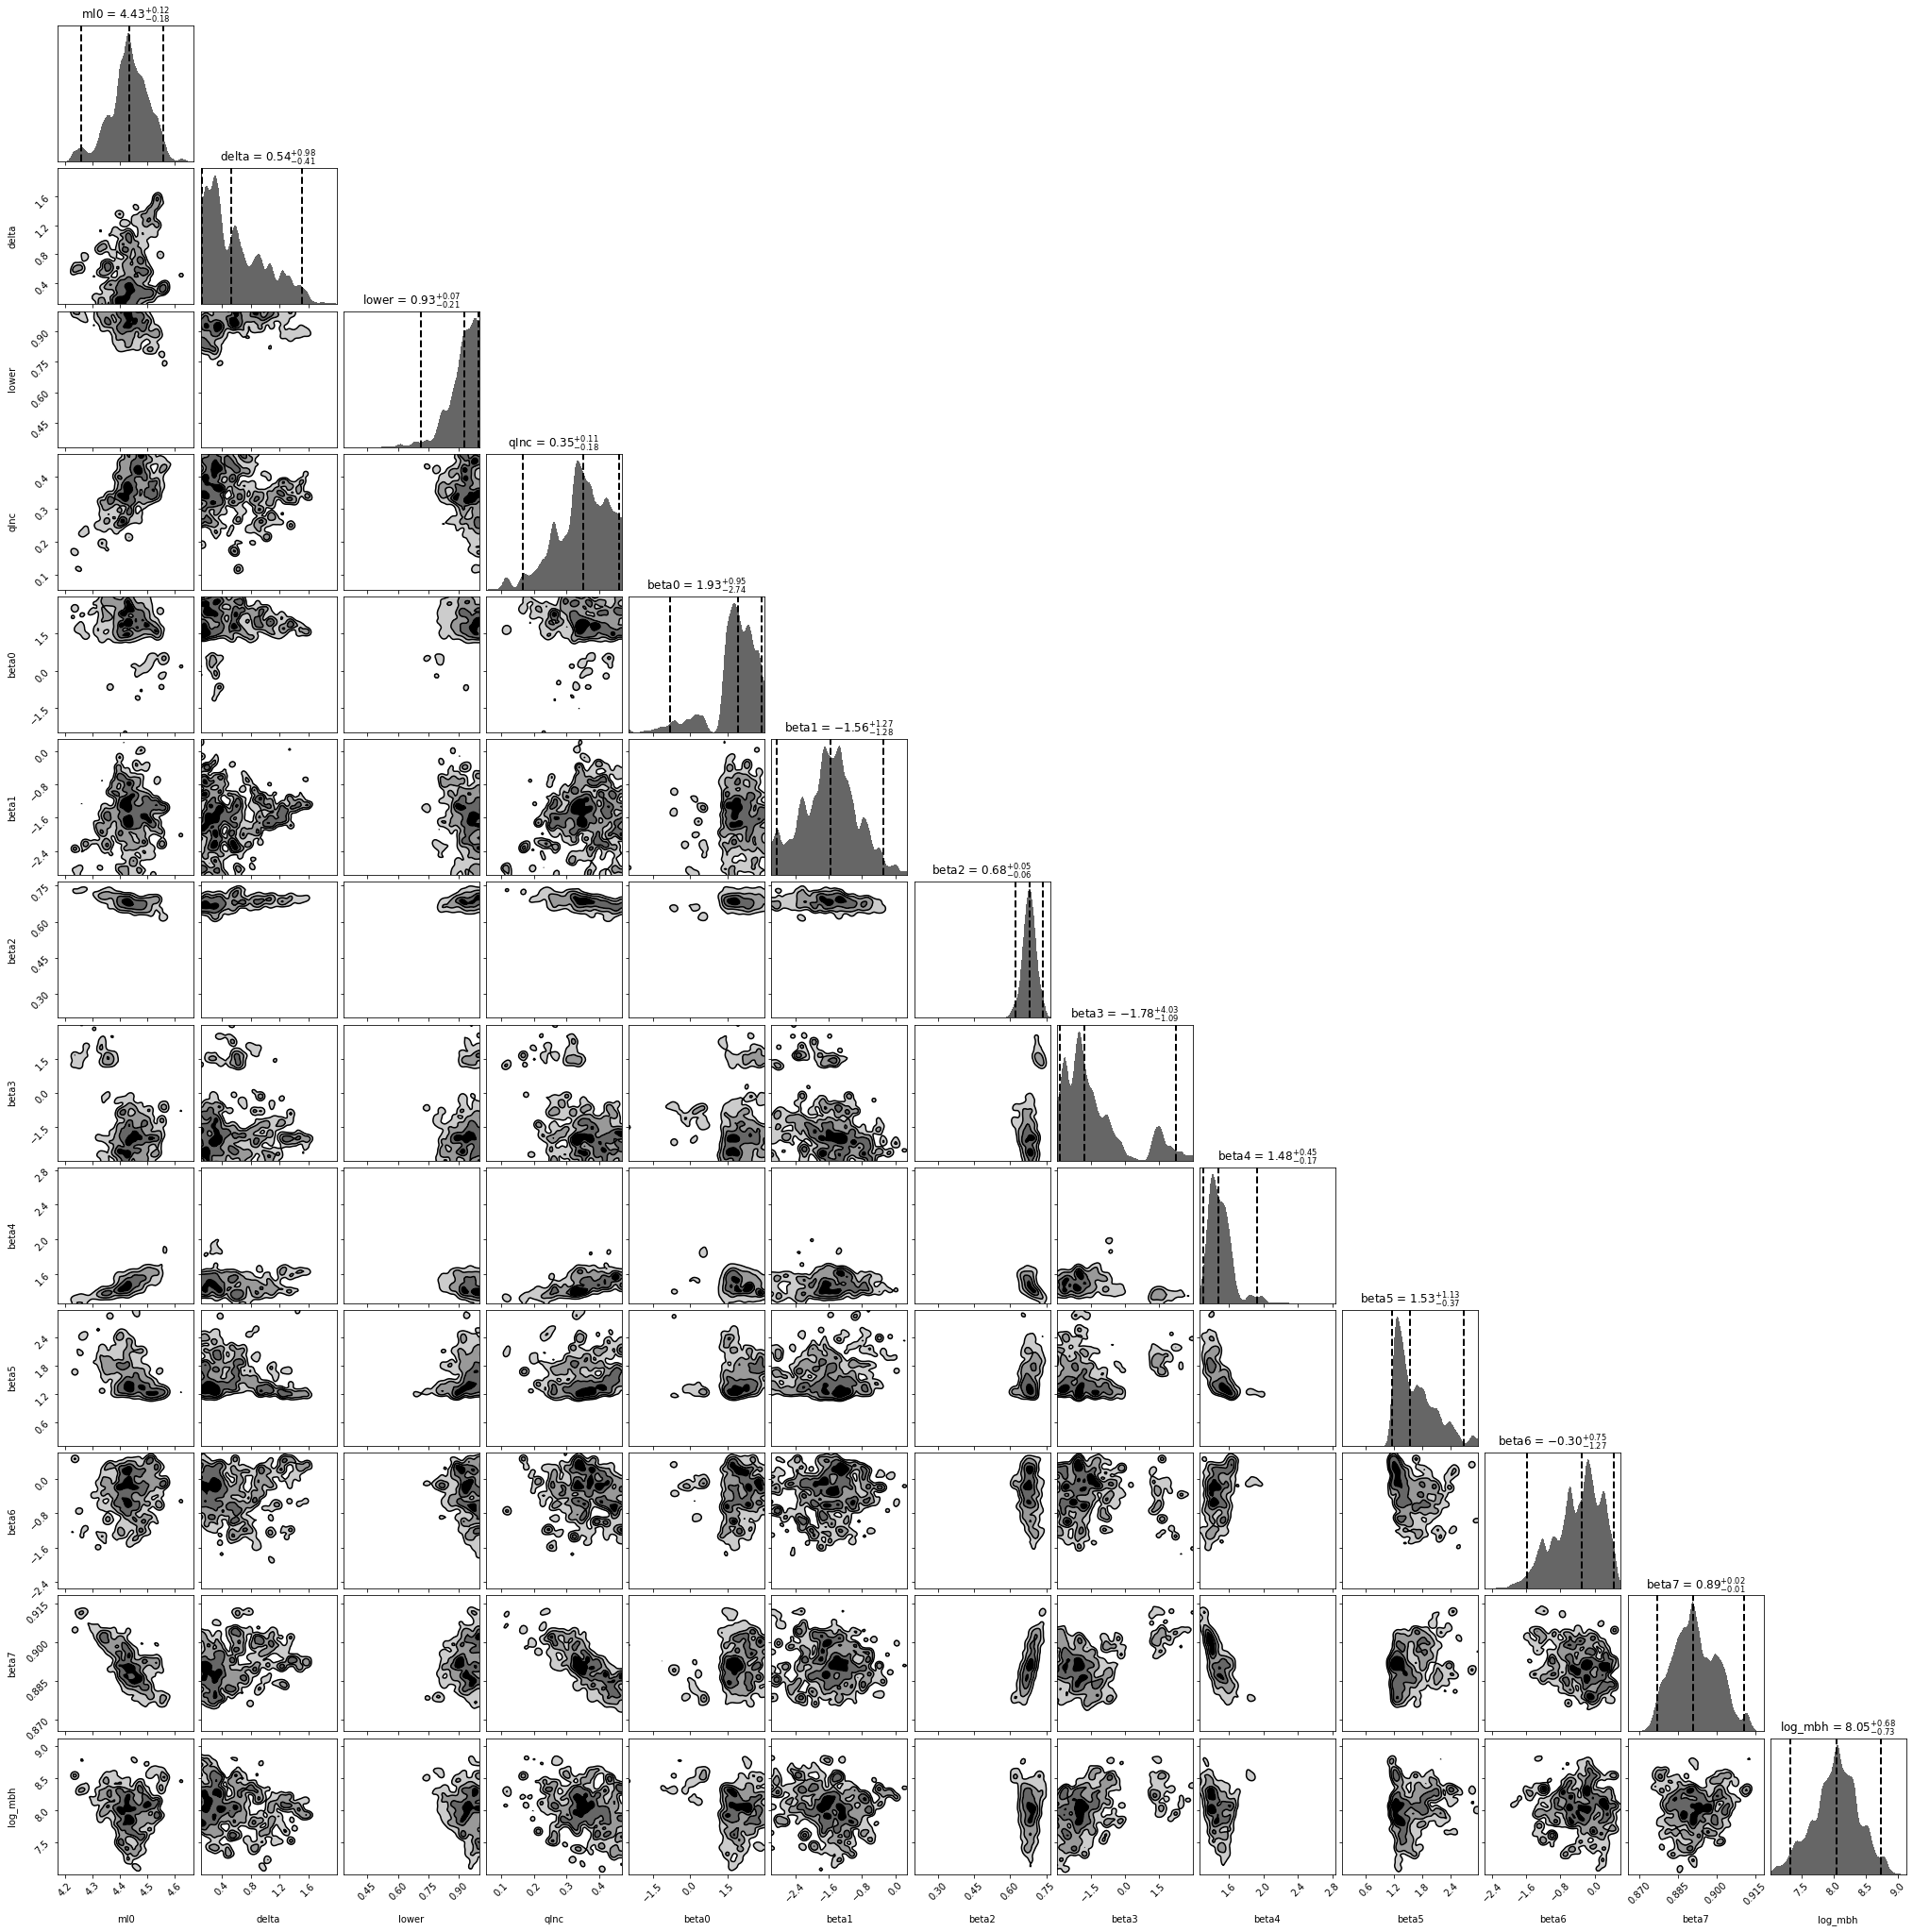

In [9]:
labels = ["ml0", "delta", "lower", "qInc", "beta0","beta1","beta2","beta3","beta4",
              "beta5","beta6","beta7", "log_mbh"]
cfig, caxes = dyplot.cornerplot(results_sim,show_titles=True,labels=labels,
                               )

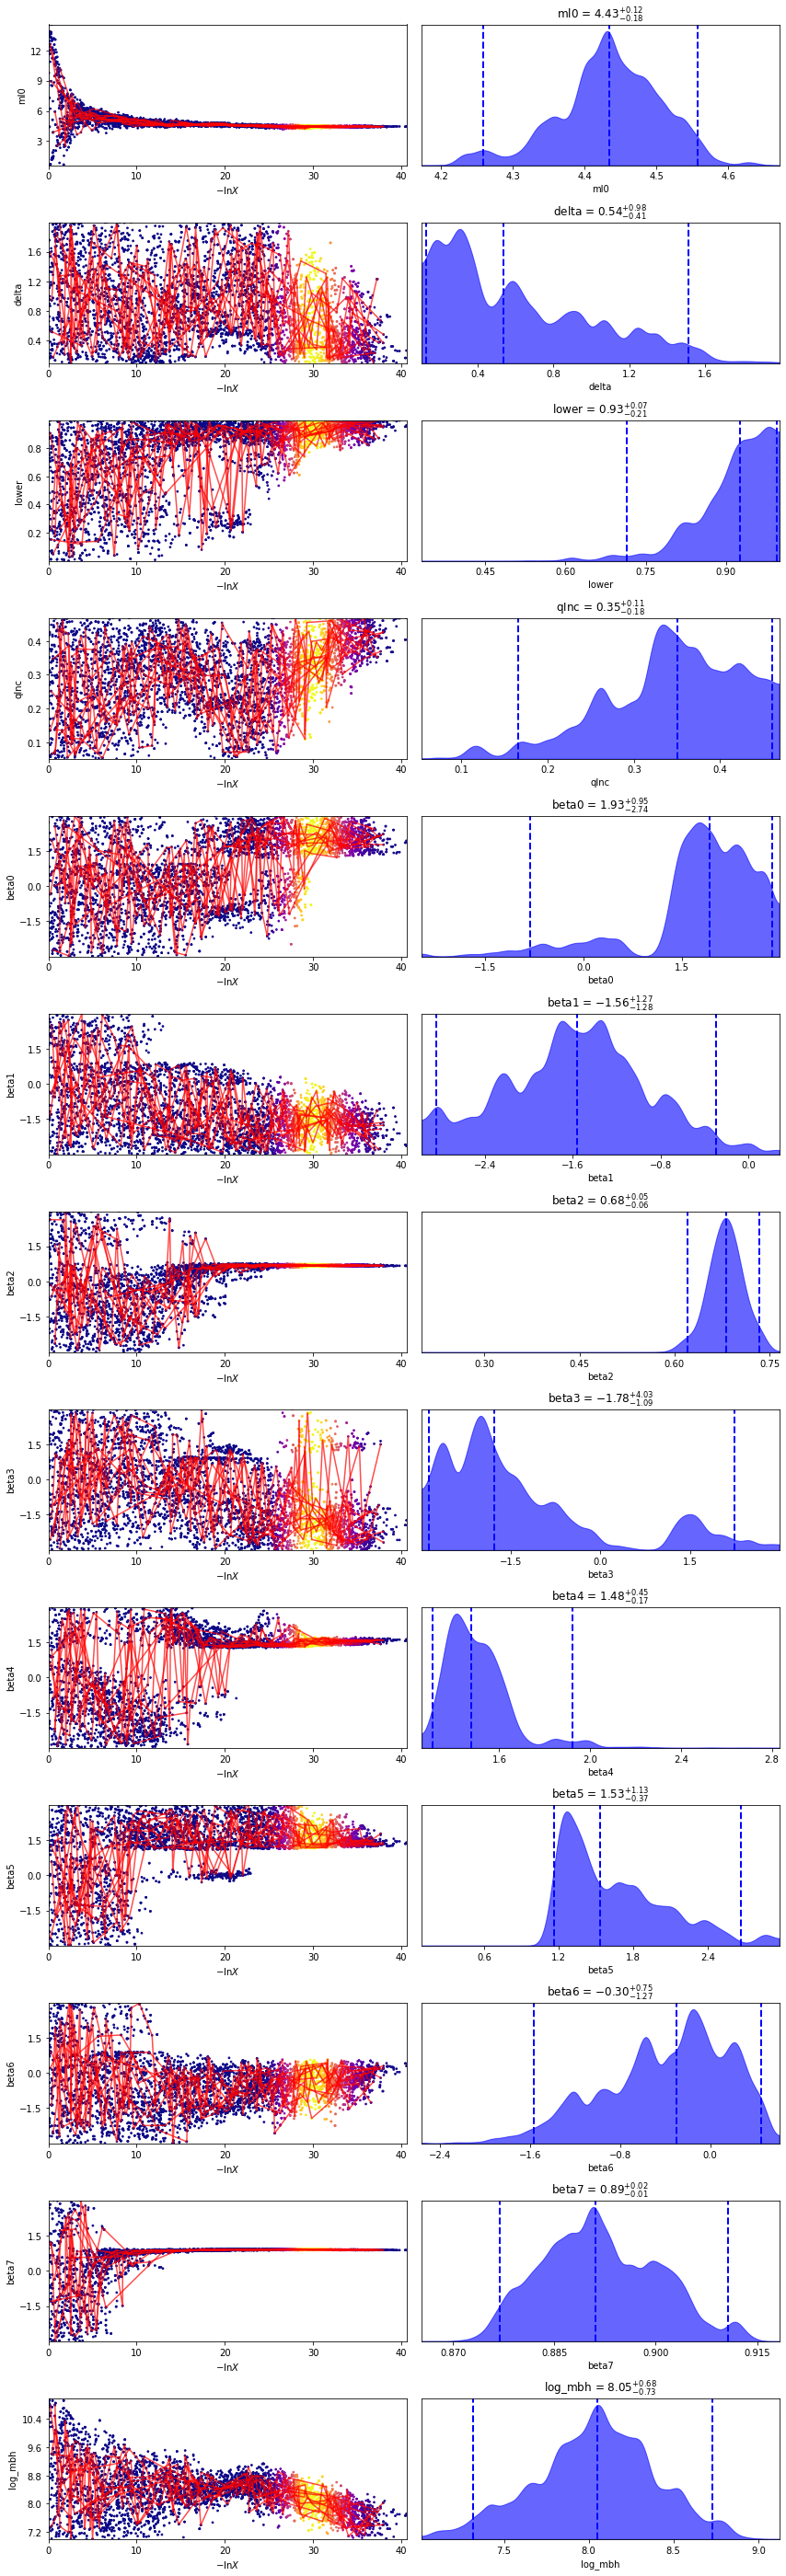

In [10]:
labels = ["ml0", "delta", "lower", "qInc", "beta0","beta1","beta2","beta3","beta4",
              "beta5","beta6","beta7", "log_mbh"]
rfig, raxes = dyplot.traceplot(results_sim, labels=labels,
                               show_titles=True, connect=True,)
plt.tight_layout()

jam_axi_rms elapsed time sec: 0.22
inc=70.6 beta_z=1.86 M/L=1 BH=9.62e+07 chi2/DOF=1.18
Total mass MGE: 3.67e+11


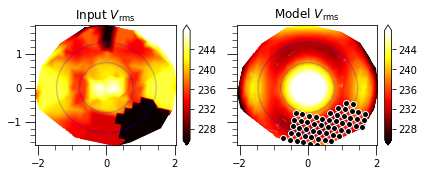

In [9]:
model(mean)
plt.tight_layout()

jam_axi_rms elapsed time sec: 0.23
inc=70.6 beta_z=1.86 M/L=1 BH=9.62e+07 chi2/DOF=1.18
Total mass MGE: 3.67e+11


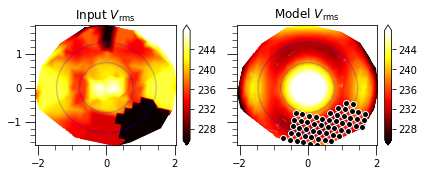

In [12]:
vrmsModel, a, b, c = Jam_model.run(plot=True, quiet=False)
plt.tight_layout()

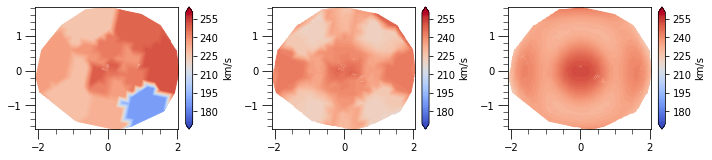

In [13]:
from plotbin.symmetrize_velfield import symmetrize_velfield

sym = symmetrize_velfield(xbin=x,ybin=y,vel_bin=vrms,sym=2)


plt.figure(figsize=(10,8))
plt.subplot(131)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrms, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(132)
plot_velfield(x=x*pixsize, y=y*pixsize, vel=sym, colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)

plt.subplot(133)

plot_velfield(x=x*pixsize, y=y*pixsize, vel=vrmsModel,colorbar=True,label='km/s',vmin=170, vmax=260, cmap=plt.cm.coolwarm, nodots=True)


plt.tight_layout()

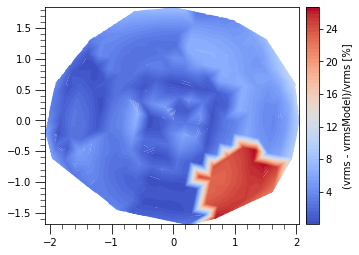

In [14]:
plot_velfield(x=x*pixsize, y=y*pixsize, vel=100*abs((vrms - vrmsModel)/vrms),colorbar=True,label='(vrms - vrmsModel)/vrms [%]', cmap=plt.cm.coolwarm, nodots=True)
